# AHRS

An **attitude and heading reference system** (AHRS) consists of sensors on three axes that provide attitude information for aircraft, including roll, pitch and yaw. These are sometimes referred to as MARG (Magnetic, Angular Rate, and Gravity) sensors and consist of either solid-state or microelectromechanical systems (MEMS) gyroscopes, accelerometers and magnetometers. They are designed to replace traditional mechanical gyroscopic flight instruments.

In [1]:
%matplotlib inline

In [15]:
from __future__ import print_function, division
import cv2         # opencv itself
import numpy as np # matrix manipulations
from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 10.0) # this controls figure size in the notebook


from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

In [3]:
from the_collector import BagReader

# def normalize(x, y, z):
# 	"""Return a unit vector"""
# 	norm = sqrt(x * x + y * y + z * z)

# 	# already a unit vector
# 	if norm == 1.0:
# 		return (x, y, z)

# 	if norm > 0.0:
# 		inorm = 1/norm
# 		x *= inorm
# 		y *= inorm
# 		z *= inorm
# 	else:
# 		raise Exception('division by zero: {} {} {}'.format(x, y, z))
# 	return (x, y, z)


# def normalize_q(q):
# 	"""Return a unit quaternion"""
# 	norm = sqrt(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)

# 	# already a unit quaternion
# 	if norm == 1.0:
# 		return q

# 	if norm > 0:
# 		inorm = 1/norm
# 		qo = [x*inorm for x in q]
# 	else:
# 		raise Exception('normalize div by 0')
# 	return qo

def quat2euler(q):
	"""
	Returns the euler representation (in degrees) of a quaternion. Note, the
	heading is wrapped between 0-360 degrees.

	In:
		[q0 q1 q2 q3] = [w x y z]
	out:
		(roll, pitch, yaw) in degrees
	"""
	q0, q1, q2, q3 = q
	roll = atan2(2.0*q2*q3-2.0*q0*q1, 2.0*q0*q0+2.0*q3*q3-1.0)
	pitch = -asin(2.0*q1*q3+2.0*q0*q2)
	heading = atan2(2.0*q1*q2-2.0*q0*q3, 2.0*q0*q0+2.0*q1*q1-1.0)

	heading = heading if heading <= 2*pi else heading-2*pi
	heading = heading if heading >= 0 else heading+2*pi

	return map(rad2deg, (roll, pitch, heading))

In [4]:
# def Orientation(accel, mag, deg=True):
#     ax, ay, az = normalize(*accel)
#     mx, my, mz = nobag = BagReader()
# bag.use_compression = True
# cal = bag.load('imu-1-2.json')rmalize(*mag)
    
#     roll = atan2(ay, az)
#     pitch = atan2(-ax, ay*sin(roll)+az*cos(roll))

#     heading = atan2(
#         mz*sin(roll) - my*cos(roll),
#         mx*cos(pitch) + my*sin(pitch)*sin(roll) + mz*sin(pitch)*cos(roll)
#     )

#     if deg:
#         roll *= 180/pi
#         pitch *= 180/pi
#         heading *= 180/pi

#         heading = heading if heading >= 0.0 else 360 + heading
#         heading = heading if heading <= 360 else heading - 360
#     else:
#         heading = heading if heading >= 0.0 else 2*pi + heading
#         heading = heading if heading <= 2*pi else heading - 2*pi

#     return (roll, pitch, heading)

```python
class AHRS(object):
	def __init__(self, q=None):
		if q is None:
			q = (1, 0, 0, 0)
		q = normalize_q(q)
		self.q = q

	def updateAGM(self, a, m, g, beta, dt):
		"""
		q - current quaternion
		a - acceleration [g's], this will be normalize
		m - magnetometer readings [uT], this will be normalized
		g - gyro readings [rad/sec]
		beta - function of sensor noise
		dt - time step [sec]
		"""
		q0, q1, q2, q3 = self.q
		gx, gy, gz = (deg2rad(x) for x in g)
		ax, ay, az = a
		mx, my, mz = m

		# Rate of change of quaternion from gyroscope
		qDot1 = 0.5 * (-q1 * gx - q2 * gy - q3 * gz)
		qDot2 = 0.5 * (q0 * gx + q2 * gz - q3 * gy)
		qDot3 = 0.5 * (q0 * gy - q1 * gz + q3 * gx)
		qDot4 = 0.5 * (q0 * gz + q1 * gy - q2 * gx)

		ax, ay, az = normalize(ax, ay, az)
		mx, my, mz = normalize(mx, my, mz)

		# Auxiliary variables to avoid repeated arithmetic
		_2q0mx = 2.0 * q0 * mx
		_2q0my = 2.0 * q0 * my
		_2q0mz = 2.0 * q0 * mz
		_2q1mx = 2.0 * q1 * mx
		_2q0 = 2.0 * q0
		_2q1 = 2.0 * q1
		_2q2 = 2.0 * q2
		_2q3 = 2.0 * q3
		_2q0q2 = 2.0 * q0 * q2
		_2q2q3 = 2.0 * q2 * q3
		q0q0 = q0 * q0
		q0q1 = q0 * q1
		q0q2 = q0 * q2
		q0q3 = q0 * q3
		q1q1 = q1 * q1
		q1q2 = q1 * q2
		q1q3 = q1 * q3
		q2q2 = q2 * q2
		q2q3 = q2 * q3
		q3q3 = q3 * q3

		# Reference direction of Earth's magnetic field
		hx = mx * q0q0 - _2q0my * q3 + _2q0mz * q2 + mx * q1q1 + _2q1 * my * q2 + _2q1 * mz * q3 - mx * q2q2 - mx * q3q3
		hy = _2q0mx * q3 + my * q0q0 - _2q0mz * q1 + _2q1mx * q2 - my * q1q1 + my * q2q2 + _2q2 * mz * q3 - my * q3q3
		_2bx = sqrt(hx * hx + hy * hy)
		_2bz = -_2q0mx * q2 + _2q0my * q1 + mz * q0q0 + _2q1mx * q3 - mz * q1q1 + _2q2 * my * q3 - mz * q2q2 + mz * q3q3
		_4bx = 2.0 * _2bx
		_4bz = 2.0 * _2bz

		# Gradient decent algorithm corrective step
		s0 = -_2q2 * (2.0 * q1q3 - _2q0q2 - ax) + _2q1 * (2.0 * q0q1 + _2q2q3 - ay) - _2bz * q2 * (_2bx * (0.5 - q2q2 - q3q3) + _2bz * (q1q3 - q0q2) - mx) + (-_2bx * q3 + _2bz * q1) * (_2bx * (q1q2 - q0q3) + _2bz * (q0q1 + q2q3) - my) + _2bx * q2 * (_2bx * (q0q2 + q1q3) + _2bz * (0.5 - q1q1 - q2q2) - mz)
		s1 = _2q3 * (2.0 * q1q3 - _2q0q2 - ax) + _2q0 * (2.0 * q0q1 + _2q2q3 - ay) - 4.0 * q1 * (1 - 2.0 * q1q1 - 2.0 * q2q2 - az) + _2bz * q3 * (_2bx * (0.5 - q2q2 - q3q3) + _2bz * (q1q3 - q0q2) - mx) + (_2bx * q2 + _2bz * q0) * (_2bx * (q1q2 - q0q3) + _2bz * (q0q1 + q2q3) - my) + (_2bx * q3 - _4bz * q1) * (_2bx * (q0q2 + q1q3) + _2bz * (0.5 - q1q1 - q2q2) - mz)
		s2 = -_2q0 * (2.0 * q1q3 - _2q0q2 - ax) + _2q3 * (2.0 * q0q1 + _2q2q3 - ay) - 4.0 * q2 * (1 - 2.0 * q1q1 - 2.0 * q2q2 - az) + (-_4bx * q2 - _2bz * q0) * (_2bx * (0.5 - q2q2 - q3q3) + _2bz * (q1q3 - q0q2) - mx) + (_2bx * q1 + _2bz * q3) * (_2bx * (q1q2 - q0q3) + _2bz * (q0q1 + q2q3) - my) + (_2bx * q0 - _4bz * q2) * (_2bx * (q0q2 + q1q3) + _2bz * (0.5 - q1q1 - q2q2) - mz)
		s3 = _2q1 * (2.0 * q1q3 - _2q0q2 - ax) + _2q2 * (2.0 * q0q1 + _2q2q3 - ay) + (-_4bx * q3 + _2bz * q1) * (_2bx * (0.5 - q2q2 - q3q3) + _2bz * (q1q3 - q0q2) - mx) + (-_2bx * q0 + _2bz * q2) * (_2bx * (q1q2 - q0q3) + _2bz * (q0q1 + q2q3) - my) + _2bx * q1 * (_2bx * (q0q2 + q1q3) + _2bz * (0.5 - q1q1 - q2q2) - mz)

		s0, s1, s2, s3 = normalize_q((s0, s1, s2, s3))

		# Apply feedback step
		qDot1 -= beta * s0
		qDot2 -= beta * s1
		qDot3 -= beta * s2
		qDot4 -= beta * s3

		q0 += qDot1 * dt
		q1 += qDot2 * dt
		q2 += qDot3 * dt
		q3 += qDot4 * dt

		q0, q1, q2, q3 = normalize_q((q0, q1, q2, q3))

		self.q = (q0, q1, q2, q3)

		return (q0, q1, q2, q3)

	def updateAG(self, q, a, g, beta, dt):
		q0, q1, q2, q3 = q
		gx, gy, gz = (deg2rad(x) for x in g)
		ax, ay, az = a

		# Rate of change of quaternion from gyroscope
		qDot1 = 0.5 * (-q1 * gx - q2 * gy - q3 * gz)
		qDot2 = 0.5 * (q0 * gx + q2 * gz - q3 * gy)
		qDot3 = 0.5 * (q0 * gy - q1 * gz + q3 * gx)
		qDot4 = 0.5 * (q0 * gz + q1 * gy - q2 * gx)

		# Compute feedback only if accelerometer measurement valid (avoids NaN in accelerometer normalisation)
		ax, ay, az = normalize(ax, ay, az)

		# Auxiliary variables to avoid repeated arithmetic
		_2q0 = 2.0 * q0
		_2q1 = 2.0 * q1
		_2q2 = 2.0 * q2
		_2q3 = 2.0 * q3
		_4q0 = 4.0 * q0
		_4q1 = 4.0 * q1
		_4q2 = 4.0 * q2
		_8q1 = 8.0 * q1
		_8q2 = 8.0 * q2
		q0q0 = q0 * q0
		q1q1 = q1 * q1
		q2q2 = q2 * q2
		q3q3 = q3 * q3

		# Gradient decent algorithm corrective step
		s0 = _4q0 * q2q2 + _2q2 * ax + _4q0 * q1q1 - _2q1 * ay
		s1 = _4q1 * q3q3 - _2q3 * ax + 4.0 * q0q0 * q1 - _2q0 * ay - _4q1 + _8q1 * q1q1 + _8q1 * q2q2 + _4q1 * az
		s2 = 4.0 * q0q0 * q2 + _2q0 * ax + _4q2 * q3q3 - _2q3 * ay - _4q2 + _8q2 * q1q1 + _8q2 * q2q2 + _4q2 * az
		s3 = 4.0 * q1q1 * q3 - _2q1 * ax + 4.0 * q2q2 * q3 - _2q2 * ay

		s0, s1, s2, s3 = normalize_q((s0, s1, s2, s3))

		# Apply feedback step
		qDot1 -= beta * s0
		qDot2 -= beta * s1
		qDot3 -= beta * s2
		qDot4 -= beta * s3

		# Integrate rate of change of quaternion to yield quaternion
		q0 += qDot1 * dt
		q1 += qDot2 * dt
		q2 += qDot3 * dt
		q3 += qDot4 * dt

		q0, q1, q2, q3 = normalize_q((q0, q1, q2, q3))

		self.q = (q0, q1, q2, q3)

		return (q0, q1, q2, q3)
```

# Get Data

In [5]:
bag = BagReader()
bag.use_compression = True
cal = bag.load('imu-1-2.json')

In [6]:
def split(data):
    """Separates the data from the timestamp for each sample"""
    ret = []
    rdt = []
    start = data[0][1]
    for d, ts in data:
        ret.append(d)
        rdt.append(ts - start) # produce a relative time timeline starting from 0 seconds
    return ret, rdt

In [7]:
accel, adt = split(cal['accel'])
mag, mdt = split(cal['mag'])
gyro, gdt = split(cal['gyro'])

## Calibrate Data

The bias was found in another application for this data

In [8]:
bias = [53.7, -40.2, -89.30000000000001]

In [9]:
def apply_calibration(data, bias):
    """
    Given the data and the bias, correct the data 
    """
    c_data = []
    for d in data:
        t = []
        for i in [0,1,2]:
            t.append(d[i]-bias[i])
        c_data.append(t)
            
    return c_data

In [10]:
cm = apply_calibration(mag, bias)

# Run AHRS

In [11]:
import ins_nav
ahrs = ins_nav.AHRS()

In [16]:
beta = 1.0
dt = adt[1]-adt[0]
save_r = []
save_p = []
save_y = []
for a, m, g in zip(accel, cm, gyro):
    q = ahrs.updateAGM(a,m,g,beta,dt)
    r,p,y = quat2euler(q)
    save_r.append(r)
    save_p.append(p)
    save_y.append(y)

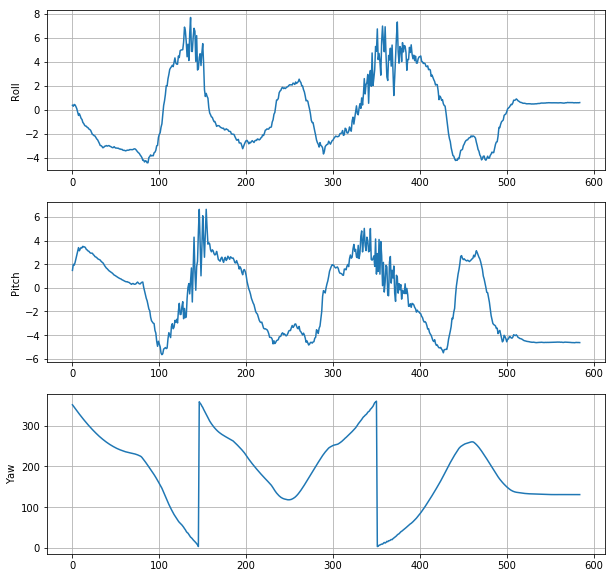

In [17]:
for i, (d, l) in enumerate(zip([save_r, save_p, save_y],['Roll','Pitch','Yaw'])):
    plt.subplot(3,1,i+1);
    plt.plot(d);
    plt.grid(True)
    plt.ylabel(l)

# Ground Truth

During the process, I grabbed camera images that we can put into a movie and "see" what is going on. Hopefully you can visually match what is happending to what is plotted above.

In [18]:
# simple function to save a video
import platform
def videoWrite(frames, fname='out.mp4'):
    frame_height, frame_width, _ = frames[0].shape
    
    # pick a good encoder for the current OS
    sys = platform.system()
    if sys in ['Darwin']:
        fourcc = 'avc1'
    else:
        fourcc = 'mjpg'
        
    out = cv2.VideoWriter(
        fname,
        cv2.VideoWriter_fourcc(*fourcc), 
        30, 
        (frame_width,frame_height))
    for frame in frames:
        out.write(frame)
    out.release()

In [19]:
frames = []
for f, ts in cal['camera']:
    frames.append(f)

videoWrite(frames, 'sensor_data.mp4')

In [20]:
from IPython.display import HTML # need this for embedding a movie in an iframe
HTML('<iframe src="sensor_data.mp4" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>')